[View in Colaboratory](https://colab.research.google.com/github/RaulMedeiros/FineTune_CNNs/blob/master/FineTune_CNNs.ipynb)

In [0]:
!rm -r *

In [0]:
!ls

# CONFIGURE PROJECT

#### Trafo config

In [0]:
# #DRIVE PATH TO DATA FOLDER
# src_folder_id = '1A5ByNWx7Nr72uOzXMy3bwLHDwShQgqYc'
# #DRIVE PATH TO EXPORT RESULTS
# out_folder_id = '196v2dmP_a5FCfopHb_J1oUay4DOwUYAa'

#### LIDC-IDRI config

In [0]:
#DRIVE PATH TO DATA FOLDER
src_folder_id = '1rCCCRNJMb8F4x2-xgwxPoDkHNEO8vkMy'
#DRIVE PATH TO EXPORT RESULTS
out_folder_id = '1CTA2uyy-CcWcnfIP_pW6ilWNRqUvMv3P'
# out_folder_id = '13Svr-AzLLP8Z0QVU5mUimFTDhtJpVfkZ' # RAUL.medeiros.rm

#### Commun config

In [0]:
class_weight= {0: 1 ,1: 4}

# Resize source image
resize_img = 32

# Base model to be fine-tuned 
# model_name_list = ['MobileNet',
#                    'ResNet50',
#                    'Xception',
#                    'VGG16',
#                    'VGG19',
#                    'InceptionV3',
#                    'InceptionResNetV2',
#                    'NASNetMobile',
#                    'NASNetLarge',
#                    'DenseNet121',
#                    'DenseNet169',
#                    'DenseNet201'] 

# Base model to be fine-tuned 
model_name_list = ['VGG19','VGG19','VGG19','VGG19','VGG19','VGG19']

# crop model at this index
cidx= -1
crop_model_idx_list =[cidx,cidx,cidx,cidx,cidx]

# fine-tune from layer
lay_2u = -10
layer_unfreeze_list = [lay_2u,lay_2u,lay_2u,lay_2u,lay_2u]

# fine-tune learning rate 
lr_CNN_list =[1e-4] #[1e-3,5e-4,1e-4,5e-5,1e-5]
lr_FC_list = [5e-4,5e-4,5e-4,5e-4,5e-4] # [5e-4] VGG19

# number of epochs 
epochs_FC = 100
epochs_CNN = 100

# number of samples in a batch
batch_size = 32

# number of folds
K_fold = 10

#TODO: MAKE IT WORK WITHOUT IT 
#name of the classes
class_names=['Non-malignant','Malignant']

#SAVE MODEL
save = False

#Show outputs
show = False

In [0]:
# Temporary Folders
src_path= './data'
out_path= './out' 

import os
os.makedirs("./out/", exist_ok=True)
file = open("./out/log.txt","w") 


In [0]:
# import numpy as np

# from sklearn.naive_bayes import MultinomialNB
# from sklearn import svm
# from sklearn.neighbors.nearest_centroid import NearestCentroid
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.ensemble import GradientBoostingClassifier

# # SELECT INDEXS OF CLASSIFIERS TO USE INTO TRANSFER LEARNING STAGES
# idxs = [1,2,3,5,7]

# clf_name_list = ['Nearest_Centroid',             #0
#                  'Multinomial_NB',               #1
#                  '5_Nearest_Neighbors ',         #2 
#                  'Random_Forest_Classifier',     #3
#                  'Gradient_Boosting_Classifier', #4
#                  'SVM linear',                   #5
#                  'SVM poly',                     #6
#                  'SVM rbf',                      #7
#                  'SVM sigmoid']                  #8

# clf_list = [NearestCentroid(), 
#             MultinomialNB(),
#             KNeighborsClassifier(n_neighbors=5),
#             RandomForestClassifier(n_estimators=3000, max_depth=6, random_state=0,class_weight="balanced"),
#             GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0),
#             svm.SVC(kernel='linear',class_weight="balanced"),
#             svm.SVC(kernel='poly',class_weight="balanced"),
#             svm.SVC(kernel='rbf',class_weight="balanced"),
#             svm.SVC(kernel='sigmoid',class_weight="balanced"),
#             MLPClassifier(max_iter=3000,solver='adam',learning_rate_init=5e-04,tol=1e-3)
#            ]

# clf_name_list = np.array(clf_name_list)[idxs]
# clf_list = np.array(clf_list)[idxs]

# print(clf_name_list,clf_list)

In [8]:
import numpy as np

from sklearn.naive_bayes import MultinomialNB
from sklearn import svm
from sklearn.neighbors.nearest_centroid import NearestCentroid
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from scipy.stats import randint as sp_randint

# SELECT INDEXS OF CLASSIFIERS TO USE INTO TRANSFER LEARNING STAGES
idxs = [0,1,2,3,4,5]


clf_name_list = np.array(['Naive Bayes', #0
                         'Multilayer Perceptron', #1
                         'Nearest_Neighbors',    #2 
                         'Random Forest',        #3
                         'SVM Linear',           #4
                         'SVM RBF'])             #5

clf_list = np.array([ 
              MultinomialNB(),        
              MLPClassifier(max_iter=3000,solver='adam',learning_rate_init=5e-04,tol=1e-3),      
              KNeighborsClassifier(n_jobs=1),   
              RandomForestClassifier(class_weight="balanced",n_jobs=1),
              svm.SVC(kernel='linear',class_weight="balanced",probability=True,max_iter=4000,tol=1e-3),
              svm.SVC(kernel='poly',class_weight="balanced",probability=True,max_iter=4000,tol=1e-3)
          ])

# specify parameters and distributions to sample from
param_dist_list = np.array([ 
                    #Bayes
                    None, 
                    #MLP
                    {"hidden_layer_sizes": list(np.arange(2,1001))},
                    # KNN
                    {"n_neighbors": [1,3,5,7,9]}, 
                    # Random Forest                   
                    {  "n_estimators": [3000],
                    "max_depth": [6, None],
                    "max_features": sp_randint(1, 6),
                    "min_samples_split": sp_randint(2,6),
                    "min_samples_leaf": sp_randint(1, 6),
                    "bootstrap": [True, False],
                    "criterion": ["gini", "entropy"]},
                    # SVM Linear
                    {'kernel': ['linear'], 'C': [2**i for i in range(-5,15)]},
                    # SVM RBF    
#                     {'kernel': ['rbf'], 'gamma': [2**i for i in range(-15,3)], 'C': [2**i for i in range(-5,15)]}
                    {'kernel': ['poly'], 'degree': [3, 5, 7 ,9], 'C': [2**i for i in range(-5,15)]}, 
                    ])



n_iter_search_list =np.array([0,10,5,10,10,10])

clf_name_list = np.array(clf_name_list[idxs])
clf_list = np.array(clf_list[idxs])
param_dist_list = np.array(param_dist_list[idxs])
n_iter_search_list = np.array(n_iter_search_list[idxs])

print(clf_name_list,clf_list,param_dist_list,n_iter_search_list)

['Naive Bayes' 'Multilayer Perceptron' 'Nearest_Neighbors' 'Random Forest'
 'SVM Linear' 'SVM RBF'] [MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)
 MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.0005, max_iter=3000, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.001, validation_fraction=0.1,
       verbose=False, warm_start=False)
 KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')
 RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_sample

In [9]:
import keras
from keras.preprocessing.image import ImageDataGenerator

#       datagen = ImageDataGenerator(
#                                     featurewise_center=False,
#                                     samplewise_center=False,
#                                     featurewise_std_normalization=False,
#                                     samplewise_std_normalization=False,
#                                     zca_whitening=False,
#                                     rotation_range=45,
#                                     width_shift_range=0.25,
#                                     height_shift_range=0.25,
#                                     horizontal_flip=True,
#                                     vertical_flip=False,
#                                     zoom_range=0.5,
#                                     channel_shift_range=0.5,
#                                     fill_mode='nearest')
#       datagen = ImageDataGenerator(
#                                     featurewise_center=False,
#                                     samplewise_center=False,
#                                     featurewise_std_normalization=False,
#                                     samplewise_std_normalization=False,
#                                     zca_whitening=False,
#                                     rotation_range=0,
#                                     width_shift_range=0.125,
#                                     height_shift_range=0.125,
#                                     horizontal_flip=True,
#                                     vertical_flip=False,
#                                     fill_mode='nearest')
datagen = ImageDataGenerator(
    featurewise_center=True, # set input mean to 0 over the dataset
    featurewise_std_normalization=True,  # divide inputs by std of the dataset
    rotation_range=40,  # randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.2,# randomly shift images horizontally (fraction of total width)
    height_shift_range=0.2, # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,  # randomly flip images
    vertical_flip=True  # randomly flip images  
  )

# datagen = None

Using TensorFlow backend.


# LOAD DATA FROM DRIVE

**Authenticate and create the PyDrive client**

In [0]:
# Install the PyDrive wrapper & import libraries.
# This only needs to be done once per notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

**Donwload and Unzip Data.zip**

In [11]:
!rm -r data
!pip3 install -q pandas
import pandas as pd

def load_dataset(folder_id):
  """Download and unzip dataset"""   

  info = pd.DataFrame(drive.ListFile({'q': "'"+folder_id +"' in parents and trashed=false" }).GetList())  
  zip_id = info['id'].values[0]  
  downloaded = drive.CreateFile({'id': zip_id })
  
  downloaded.GetContentFile('./dataset.zip')  
  !unzip -q dataset.zip
  !rm dataset.zip
  !ls
  return True

#Load and Unconpress data
load_dataset(src_folder_id)

rm: cannot remove 'data': No such file or directory
data  datalab  out


True

**Sample of files into class/folder 0**

In [12]:
!ls data

0  1


# Export DATALOG


In [0]:
def export_log(out_drive_folder_id,log_model_config):    
  #ZIP log folder
  !zip -r -q $log_model_config out
  !rm -r out
    
  #TRANSFER TO DRIVE
  # Authenticate and create the PyDrive client.
  # This only needs to be done once per notebook.
  auth.authenticate_user()
  gauth = GoogleAuth()
  gauth.credentials = GoogleCredentials.get_application_default()
  drive = GoogleDrive(gauth)
  
  '''Export colab folder to drive folder '''
  file = drive.CreateFile({"parents": [{"kind": "drive#fileLink",
                                        "id": out_drive_folder_id}]}) 
  # Export file
  file.SetContentFile(log_model_config)
  file.Upload() 
  !rm $log_model_config
  return True

#DATA LOADER

In [0]:
import os
import numpy as np
import random
import glob

# https://opencv.org/
!apt-get -qq install -y libsm6 libxext6 && pip install -q -U opencv-python
import cv2

class Dataset:
  def load_img(img_path,target_size=32):
    """Load dataset"""
    #LOAD image to be deep extracted         
    if (img_path.endswith('jpg') or img_path.endswith('png')):
        img = cv2.imread(img_path)
    elif (img_path.endswith('txt')):
        img = np.loadtxt(img_path).copy()
    elif (img_path.endswith('npy')):
        img = np.load(img_path).copy()  
    img = cv2.resize(img, (target_size,target_size), interpolation = cv2.INTER_NEAREST)
    return img
  
  def load_data(path='./data',resize=299,zero_centred=True,normalized=True,one_hot=False,verbose=False,dtype=np.uint8):
        
    img_paths = glob.glob(path+'/*/*')
    
    data = np.empty((len(img_paths),resize, resize,3), dtype=dtype)
    labels = np.empty((len(img_paths)), dtype=dtype)

    for idx,img_path in enumerate(img_paths):
      data[idx, ...] = Dataset.load_img(img_path,resize)          
      labels[idx, ...] = int(img_path.split('/')[-2])

#     if(zero_centred):
#       data = Dataset.remove_mean(data)   
      
#     if(normalized):
#       data = Dataset.normalize(data)

      num_classes = len(np.unique(labels))
    
    if(verbose):
      Dataset.print_log(data,labels,num_classes)
      
    if(one_hot):     
      labels = np_utils.to_categorical(labels, num_classes)
    
    return np.array(data),np.array(labels),num_classes  
  
  def normalize(data):
    res = []
    for img in data:
      #TODO:
      pass
    return data
  
  def remove_mean(data):
    res = []
    data-=np.mean(data)
    return data
  
  def print_log(data,labels,num_classes):
    print('Loaded DS has:', len(data), 'samples /',num_classes,'classes')
    print('samples per class = ',[np.sum([1 for i in labels if i == x]) for x in range(num_classes)])
    return True

# LOG RELATED FUNCTIONS

In [0]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import cross_val_score, cross_validate
from sklearn import metrics

from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold

from sklearn.metrics import  *

import tensorflow as tf

import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import itertools

def auc_roc(y_true, y_pred):
    # any tensorflow metric
    value, update_op = tf.contrib.metrics.streaming_auc(y_pred, y_true)

    # find all variables created for this metric
    metric_vars = [i for i in tf.local_variables() if 'auc_roc' in i.name.split('/')[1]]

    # Add metric variables to GLOBAL_VARIABLES collection.
    # They will be initialized for new session.
    for v in metric_vars:
      tf.add_to_collection(tf.GraphKeys.GLOBAL_VARIABLES, v)

    # force to update metric values
    with tf.control_dependencies([update_op]):
      value = tf.identity(value)
      return value
  
def log_cofusion_matrix(y_true, y_pred, log_path,clf_name,class_names,show=True):
  
  def plot_confusion_matrix(cm, 
                            log_path,
                            class_names,
                            show=True,
                            normalize=True,
                            cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    cbar = plt.colorbar()
    cbar.ax.tick_params(labelsize=14) 
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, fontsize=16)
    plt.yticks(tick_marks, class_names,fontsize=16)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center", fontsize=20,
                 color="white" if cm[i, j] > thresh else "black")

        
#     plt.tight_layout()
    plt.ylabel('True label', fontsize=18)
    plt.xlabel('Predicted label', fontsize=18)
    plt.title(clf_name+' '+"Confusion Matrix", fontsize=20)
    plt.grid(False)

    log_output_path = log_path+'/'+clf_name+'/'
    os.makedirs(log_output_path, exist_ok=True)
    
    plt.savefig(log_output_path+clf_name+'_Normalized_confusion_matrix.png')
    plt.savefig(log_output_path+clf_name+'_Normalized_confusion_matrix.svg')
    plt.savefig(log_output_path+clf_name+'_Normalized_confusion_matrix.eps')
    
    if (show): 
      plt.show()
    else: 
      plt.clf()

    return True
    
  # Compute confusion matrix
  cnf_matrix = confusion_matrix(y_true, y_pred)
  np.set_printoptions(precision=3)

  # Plot normalized confusion matrix
  plot_confusion_matrix(cnf_matrix, 
                        log_path,
                        show=show,
                        class_names=class_names, 
                        normalize=True)
  return True
    
# def log_final_metrics(log_name,y_pred,y_true,file):
#     # METRICS            
#     print('\n\n ==== Model Evaluation '+log_name+' ====\n ')
#     file.write('\n\n ==== Model Evaluation '+log_name+' ====\n ')
#     print(classification_report(np.array(y_true), np.array(y_pred)))
#     file.write(classification_report(np.array(y_true), np.array(y_pred)))
#     file.write('==========================')
#     return True
    
# def init_log_var(plane,modelName,target_size,layer2Freeze):
#     """ this function initialize the log variables and paths""" 
#     output_name = str(np.random.randint(10000000))+'_'+plane+'_'+modelName+'_'+str(target_size)+'_'+str(layer2Freeze)
#     print(output_name)
    
#     log_path = output_path+'_'+output_name+'/'
#     os.makedirs(log_path, exist_ok=True)
    
#     file = open(log_path+output_name+".txt","w") 
#     file.write(output_name+'\n')
#     return file,log_path,output_name

  
def print_fold_log(log_list,clf_name_list,log_path,class_names,show):
  
  y_true_list, y_pred_list = log_list[-1]
 
  for y_true, y_pred,clf_name in zip(y_true_list, y_pred_list,clf_name_list):
    
    if (show):
      print('>>> '+clf_name)
      print(classification_report(y_true, y_pred))      

      print('recall_micro',metrics.recall_score(y_true, y_pred,average='micro'))
      print('recall_macro',metrics.recall_score(y_true, y_pred,average='macro'))
      print('recall_weighted',metrics.recall_score(y_true, y_pred,average='weighted'))
      
      print('precision_micro',metrics.precision_score(y_true, y_pred,average='micro'))
      print('precision_macro',metrics.precision_score(y_true, y_pred,average='macro'))
      print('precision_weighted',metrics.precision_score(y_true, y_pred,average='weighted'))
      
      print('auc_micro',metrics.roc_auc_score(y_true, y_pred,average='micro'))
      print('auc_macro',metrics.roc_auc_score(y_true, y_pred,average='macro'))
      print('auc_weighted',metrics.roc_auc_score(y_true, y_pred,average='weighted'))

    #Confusion Matrix
    log_cofusion_matrix(y_pred,y_true,log_path,clf_name,class_names,show)
    
  return True
  
def plot_history(history,out_path,file_name,show=True):
  
    log_path =out_path+'/'+file_name+'/'
    os.makedirs(log_path, exist_ok=True)
    
    # summarize history for accuracy
    plt.plot(history['acc'])
    plt.plot(history['val_acc'])
    plt.grid(True)
    plt.title('accuracy evolution')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig(log_path+file_name+'_accuracy.png')
    if (show): 
      plt.show()
    else: 
      plt.clf()
      
    # summarize history for loss
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.grid(True)
    plt.title('loss evolution')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig(log_path+file_name+'_loss.png')
    if (show): 
      plt.show()
    else: 
      plt.clf()
      
#     # summarize history for loss
#     plt.plot(history['auc_roc'])
#     plt.plot(history['val_auc_roc'])
#     plt.grid(True)
#     plt.title('auc roc evolution')
#     plt.ylabel('AUC ROC')
#     plt.xlabel('epoch')
#     plt.legend(['train', 'test'], loc='upper left')
#     plt.savefig(log_path+file_name+'_auc.png')
#     if (show): 
#       plt.show()
#     else: 
#       plt.clf()
    return True

def final_plot(log,log_name,out_path,save=True): 
  if (save):
    np.save(out_path+'/'+log_name+'.npy',np.array(log))
 
  def multiple_hist_plot(keys,log_name,file_name,log):
    fig, ax = plt.subplots()

    colors = ["windows blue","red"]
    clrs = sns.xkcd_palette(colors)

    plot_names = ['Train','Test']
    
    mean_plot_list = []
    for idx, key in enumerate(keys):

      hist_acc = [ hist[key] for hist in np.array(log)[:,-1]]
      epochs = list(range(len(hist_acc[0])))

      max_ACC = np.amax(hist_acc, axis=0)
      mean_ACC = np.mean(hist_acc, axis=0)
      min_ACC = np.amin(hist_acc, axis=0)

      plot, = plt.plot(mean_ACC,alpha=1,c=clrs[idx],label=plot_names[idx])
      mean_plot_list.append(plot)

      [plt.plot(y,alpha=0.2,c=clrs[idx]) for y in hist_acc]
      plt.fill_between(epochs, min_ACC, max_ACC,alpha=0.05,facecolor=clrs[idx])

    leg = plt.legend(handles=[mean_plot_list[0],mean_plot_list[1]],fontsize=20,frameon=True)
    leg.get_frame().set_edgecolor('black')

    plt.grid(True)
    plt.title('Model '+file_name)
    plt.ylabel(file_name)
    plt.xlabel('epoch')

    log_output_path = out_path+'/'+log_name+'/'
    os.makedirs(log_output_path, exist_ok=True)
    
    plt.savefig(log_output_path+file_name+'.png')
    plt.savefig(log_output_path+file_name+'.svg')
    plt.savefig(log_output_path+file_name+'.eps')  

    plt.show()
    return True
  
  multiple_hist_plot(['acc','val_acc'],log_name,'accuracy',log=log)
  multiple_hist_plot(['loss','val_loss'],log_name,'loss',log=log)
#   multiple_hist_plot(['auc_roc','val_auc_roc'],log_name,'auc roc',log=log)

  return True

# MODEL RELATED FUNCTIONS

In [0]:
import numpy as np

from keras import backend as K
K.tensorflow_backend._get_available_gpus()

from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from keras.applications.xception import Xception
from keras.applications.mobilenet import MobileNet
from keras.applications.resnet50 import ResNet50
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_resnet_v2 import InceptionResNetV2

from keras.applications.vgg19 import preprocess_input

from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalMaxPooling2D ,MaxPooling2D, Flatten ,Input, Dropout
# from keras import backend as K
from keras.utils import np_utils
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD
from keras import optimizers

from sklearn.model_selection import RandomizedSearchCV
from time import time


def evaluate(clf,x_test,y_test):
    y_hat = np.array(clf.predict(x_test)) 
    
    print(y_hat,y_test)
# TODO FIX THIS
#     y_prob = np.array([a[x] for a,x in zip(y_hat, np.argmax(y_hat,axis=1))])
#     print(y_hat,y_test,y_prob)
#     print('roc_auc',metrics.roc_auc_score(y_test, y_prob))

    if (len(y_test.shape) > 1):
        y_pred = np.argmax(y_hat,axis=1)
        y_true = np.argmax(y_test,axis=1)
    else:
        y_pred = y_hat
        y_true = y_test        
    return y_true.tolist(),y_pred.tolist()
  
  
def buildModel(modelName,data_shape,num_classes,cropModelIdx):
    input_tensor = Input(shape=(data_shape))
    if ('VGG16' is modelName):
        base_model = VGG16(weights='imagenet', include_top=False, input_tensor=input_tensor)    
    if ('VGG19' is modelName):
        base_model = VGG19(weights='imagenet', include_top=False, input_tensor=input_tensor)
    if ('MobileNet' is modelName):
        base_model = MobileNet(weights='imagenet', include_top=False)#, input_shape=(128,128,3),alpha=1  
    if ('ResNet50' is modelName):
        base_model = ResNet50(weights='imagenet', include_top=False)#, input_tensor=input_tensor)       
    if ('InceptionV3' is modelName):
        base_model = InceptionV3(weights='imagenet', include_top=False, input_tensor=input_tensor)
    if ('Xception' is modelName):
        base_model = Xception(weights='imagenet', include_top=False, input_tensor=input_tensor)  
    if('InceptionResNetV2' is modelName):
        base_model = InceptionResNetV2(weights='imagenet', include_top=False, input_tensor=input_tensor)

    # Adapt model to new output(number of classes)
    base_model = edit_model(base_model,num_classes,cropModelIdx)

    return base_model
  
  
def edit_model(base_model,num_classes,cropModelIdx):    
    # Add a Flatten layer
    x = base_model.get_layer(index=cropModelIdx).output
    x = GlobalMaxPooling2D()(x)
    x = Dropout(0.5)(x)
#     x = Flatten()(x)
    
    # Add a logistic layer (to match the number of classes)
    predictions = Dense(num_classes, activation='softmax')(x)
    
    # this is the model we will train
    model = Model(inputs=base_model.input, outputs=predictions)
    
    # unfreeze only the top layer
    for layer in model.layers[:-1]:
        layer.trainable = False            
    return model
   
    
def unfreeze_model(model,layer_2_unfreeze):
    for layer in model.layers[:layer_2_unfreeze]:
        layer.trainable = False
    for layer in model.layers[layer_2_unfreeze:]:
        layer.trainable = True    
    return model

  
def train_model(model,x_train,y_train,x_test,y_test,batch_size,epochs,class_weight,opt=None,datagen=None):
    # configure otimizer
    if (opt == None):
        opt=optimizers.Adam(lr=3e-04, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.01)
    
    # compile the model (should be done *after* setting layers to non-trainable)
    model.compile(optimizer=opt, loss='binary_crossentropy',metrics=['accuracy'])
    
    # train the model on the new data for a few epochs
    # this will do preprocessing and realtime data augmentation
    if (datagen == None):
        datagen = ImageDataGenerator(
            featurewise_center=True, # set input mean to 0 over the dataset
            featurewise_std_normalization=True,  # divide inputs by std of the dataset
            rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
            width_shift_range=0.1,# randomly shift images horizontally (fraction of total width)
            height_shift_range=0.1, # randomly shift images vertically (fraction of total height)
            horizontal_flip=True,  # randomly flip images
            vertical_flip=True,  # randomly flip images  
        )

    # compute quantities required for featurewise normalization
    # (std, mean, and principal components if ZCA whitening is applied)
    datagen.fit(x_train)
    
    n_classes = len(np.unique(labels))
    y_train = np_utils.to_categorical(y_train,n_classes )
    y_test = np_utils.to_categorical(y_test, n_classes )
       
    # fits the model on batches with real-time data augmentation:
    history = model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                        steps_per_epoch=len(x_train) / batch_size, epochs=epochs,
                        verbose=0, validation_data=(x_test, y_test),
                        class_weight = class_weight,
                        shuffle=True)
    return model,history.history

  
def save_model(model,out_path,hdf5=True,json=False):
    # serialize model to JSON
    if(json):
      model_json = model.to_json()
      with open(out_path+'/'+"model.json", "w") as json_file:
          json_file.write(model_json)
    
    # serialize weights to HDF5
    if(hdf5):    
      model.save_weights(out_path+'/'+"model.h5")
      
    return True

  
def extract_features(model,data_test):
    x = model.get_layer(index=-2).output
    new_model = Model(inputs=model.input, outputs=x)
    return np.array(new_model.predict(data_test))

In [0]:
import numpy as np

from keras import backend as K
K.tensorflow_backend._get_available_gpus()

from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from keras.applications.xception import Xception
from keras.applications.mobilenet import MobileNet
from keras.applications.resnet50 import ResNet50
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_resnet_v2 import InceptionResNetV2

from keras.applications.vgg19 import preprocess_input

from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalMaxPooling2D ,MaxPooling2D, Flatten ,Input, Dropout
# from keras import backend as K
from keras.utils import np_utils
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD
from keras import optimizers

from sklearn.model_selection import RandomizedSearchCV
from time import time


def evaluate(clf,x_test,y_test):
    y_hat = np.array(clf.predict(x_test)) 
    
# TODO FIX THIS
#     y_prob = np.array([a[x] for a,x in zip(y_hat, np.argmax(y_hat,axis=1))])
#     print(y_hat,y_test,y_prob)
#     print('roc_auc',metrics.roc_auc_score(y_test, y_prob))

    if (len(y_test.shape) > 1):
        y_pred = np.argmax(y_hat,axis=1)
        y_true = np.argmax(y_test,axis=1)
    else:
        y_pred = y_hat
        y_true = y_test        
    return y_true.tolist(),y_pred.tolist()
  
  
def buildModel(modelName,data_shape,num_classes,cropModelIdx):
    input_tensor = Input(shape=(data_shape))
    if ('VGG16' is modelName):
        base_model = VGG16(weights='imagenet', include_top=False, input_tensor=input_tensor)    
    if ('VGG19' is modelName):
        base_model = VGG19(weights='imagenet', include_top=False, input_tensor=input_tensor)
    if ('MobileNet' is modelName):
        base_model = MobileNet(weights='imagenet', include_top=False)#, input_shape=(128,128,3),alpha=1  
    if ('ResNet50' is modelName):
        base_model = ResNet50(weights='imagenet', include_top=False)#, input_tensor=input_tensor)       
    if ('InceptionV3' is modelName):
        base_model = InceptionV3(weights='imagenet', include_top=False, input_tensor=input_tensor)
    if ('Xception' is modelName):
        base_model = Xception(weights='imagenet', include_top=False, input_tensor=input_tensor)  
    if('InceptionResNetV2' is modelName):
        base_model = InceptionResNetV2(weights='imagenet', include_top=False, input_tensor=input_tensor)

    # Adapt model to new output(number of classes)
    base_model = edit_model(base_model,num_classes,cropModelIdx)

    return base_model
  
  
def edit_model(base_model,num_classes,cropModelIdx):    
    # Add a Flatten layer
    x = base_model.get_layer(index=cropModelIdx).output
    x = GlobalMaxPooling2D()(x)
    x = Dropout(0.5)(x)
#     x = Flatten()(x)
    
    # Add a logistic layer (to match the number of classes)
    predictions = Dense(num_classes, activation='softmax')(x)
    
    # this is the model we will train
    model = Model(inputs=base_model.input, outputs=predictions)
    
    # unfreeze only the top layer
    for layer in model.layers[:-1]:
        layer.trainable = False            
    return model
   
    
def unfreeze_model(model,layer_2_unfreeze):
    for layer in model.layers[:layer_2_unfreeze]:
        layer.trainable = False
    for layer in model.layers[layer_2_unfreeze:]:
        layer.trainable = True    
    return model

  
def train_model(model,x_train,y_train,x_test,y_test,batch_size,epochs,class_weight,opt=None,datagen=None):
    # configure otimizer
    if (opt == None):
        opt=optimizers.Adam(lr=3e-04, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.01)
    
    # compile the model (should be done *after* setting layers to non-trainable)
    model.compile(optimizer=opt, loss='binary_crossentropy',metrics=['accuracy'])
    
    # train the model on the new data for a few epochs
    # this will do preprocessing and realtime data augmentation
    if (datagen == None):
        datagen = ImageDataGenerator(
            featurewise_center=True, # set input mean to 0 over the dataset
            featurewise_std_normalization=True,  # divide inputs by std of the dataset
            rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
            width_shift_range=0.1,# randomly shift images horizontally (fraction of total width)
            height_shift_range=0.1, # randomly shift images vertically (fraction of total height)
            horizontal_flip=True,  # randomly flip images
            vertical_flip=True,  # randomly flip images  
        )

    # compute quantities required for featurewise normalization
    # (std, mean, and principal components if ZCA whitening is applied)
    datagen.fit(x_train)
    
    n_classes = len(np.unique(labels))
    y_train = np_utils.to_categorical(y_train,n_classes )
    y_test = np_utils.to_categorical(y_test, n_classes )
       
    # fits the model on batches with real-time data augmentation:
    history = model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                        steps_per_epoch=len(x_train) / batch_size, epochs=epochs,
                        verbose=0, validation_data=(x_test, y_test),
                        class_weight = class_weight,
                        shuffle=True)
    return model,history.history

  
def save_model(model,out_path,hdf5=True,json=False):
    # serialize model to JSON
    if(json):
      model_json = model.to_json()
      with open(out_path+'/'+"model.json", "w") as json_file:
          json_file.write(model_json)    
    # serialize weights to HDF5
    if(hdf5):    
      model.save_weights(out_path+'/'+"model.h5")      
    return True

  
def extract_features(model,data_test):
    x = model.get_layer(index=-2).output
    new_model = Model(inputs=model.input, outputs=x)
    return np.array(new_model.predict(data_test))
  
def hyperP_search(X,y,clf,param_dist,n_iter):
  if (param_dist!=None):
    # run randomized search
    random_search = RandomizedSearchCV(clf, param_distributions=param_dist,n_iter=n_iter,cv=5)

    start = time()
    random_search.fit(X, y)
    print("RandomizedSearchCV took %.2f seconds for %d candidates"
          " parameter settings." % ((time() - start), n_iter))
    clf = random_search.best_estimator_
  print(clf)
  return clf

# FineTune Functions

In [0]:
def transfer_learning(model, # Model to be evaluated
                      data,labels,train,test, # data
                      clf_list, # Classifiers 
                      clf_name_list, # Classifiers names
                      stage_name): # Log Variable
  
  # Extract features with 'model'
  features_train = extract_features(model,data[train])
  features_test = extract_features(model,data[test])
  
  # Log Variables
  y_pred_list = []
  y_true_list = []
  
  #For each classfier selected
  for clf ,clf_name,param_dist,n_iter in zip(clf_list,clf_name_list,param_dist_list,n_iter_search_list):  
    
      # Find Best Hyper Params
      clf = hyperP_search(features_train,labels[train],clf,param_dist,n_iter)
      
      # Train Classifier
      clf.fit(features_train,labels[train])
            
      # Compute metrics
      file_name = stage_name+'_'+clf_name
      y_true, y_pred = evaluate(clf,features_test,labels[test])
                    
      # Store Results into a Log
      y_true_list.append(y_true)          
      y_pred_list.append(y_pred)
          
  # Clear unused memory        
  del features_train
  del features_test   
  return [y_true_list,y_pred_list]

def fine_tune(model, # Model to be trained 
              data,labels,train,test, # Data
              batch_size, # Number of samples in a batch
              epochs, # Number of training epochs 
              lr,
              class_weight, #Balance beween classes
              out_path,  # Log Variable
              stage_name,
              datagen,
              show): # Log Variable
  
  # Finetune some layers of the model 
  opt=optimizers.Adam(lr=lr, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.01)
  model, history = train_model(model,data[train],labels[train],data[test],labels[test],batch_size,epochs,class_weight,opt,datagen)
  
  # ploy train and validation curves 
  plot_history(history,out_path,stage_name,show)
  
  # Compute metrics of the process of fine tune
  y_true, y_pred = evaluate(model,data[test],labels[test])
 
  return [y_true, y_pred,history]

def final_evaluation(out_path, # Log Variable
                     log_name, # Log Variable
                     log_arr, # Log with True and Predicted values for each fold
                     clf_name_list,  # Classifiers names
                     class_names,
                     save=True):
  if (save):
    np.save(out_path+'/'+log_name+'.npy',log_arr)

  y_true_list = []
  y_pred_list = []
  
  for log in log_arr:    
    y_t, y_p = log
    y_true_list.extend(y_t)
    y_pred_list.extend(y_p)

  print("======================= "+log_name+" =======================")
  for y_true, y_pred,clf_name in zip(y_true_list, y_pred_list,clf_name_list):
    
    print('>>> '+clf_name)
    print(classification_report(y_true, y_pred))
    print('accuracy',metrics.accuracy_score(y_true, y_pred)) 

    print('recall_micro',metrics.recall_score(y_true, y_pred,average='micro'))
    print('recall_macro',metrics.recall_score(y_true, y_pred,average='macro'))
    print('recall_weighted',metrics.recall_score(y_true, y_pred,average='weighted'))

    print('precision_micro',metrics.precision_score(y_true, y_pred,average='micro'))
    print('precision_macro',metrics.precision_score(y_true, y_pred,average='macro'))
    print('precision_weighted',metrics.precision_score(y_true, y_pred,average='weighted'))

    print('auc_micro',metrics.roc_auc_score(y_true, y_pred,average='micro'))
    print('auc_macro',metrics.roc_auc_score(y_true, y_pred,average='macro'))
    print('auc_weighted',metrics.roc_auc_score(y_true, y_pred,average='weighted'))

    file.write('>>> '+clf_name+'\n') 
    file.write(classification_report(y_true, y_pred))     
    
    file.write('accuracy '+str(metrics.accuracy_score(y_true, y_pred))+'\n') 

    
    file.write('recall_micro '+str(metrics.recall_score(y_true, y_pred,average='micro'))+'\n') 
    file.write('recall_macro '+str(metrics.recall_score(y_true, y_pred,average='macro'))+'\n') 
    file.write('recall_weighted '+str(metrics.recall_score(y_true, y_pred,average='weighted'))+'\n') 

    file.write('precision_micro '+str(metrics.precision_score(y_true, y_pred,average='micro'))+'\n') 
    file.write('precision_macro '+str(metrics.precision_score(y_true, y_pred,average='macro'))+'\n') 
    file.write('precision_weighted '+str(metrics.precision_score(y_true, y_pred,average='weighted'))+'\n') 
    
    file.write('auc_micro '+str(metrics.roc_auc_score(y_true, y_pred,average='micro'))+'\n') 
    file.write('auc_macro '+str(metrics.roc_auc_score(y_true, y_pred,average='macro'))+'\n') 
    file.write('auc_weighted '+str(metrics.roc_auc_score(y_true, y_pred,average='weighted'))+'\n'+'\n') 
    
    #Confusion Matrix
    log_path = out_path+'/'+log_name+'/'
    log_cofusion_matrix(y_pred,y_true,log_path,clf_name,class_names,True)
    
  return True


# Execution

In [19]:
import psutil
print(psutil.virtual_memory())

#Load Dataset    
data,labels,num_classes = Dataset.load_data(src_path,
                                            resize =resize_img,
                                            zero_centred=True,
                                            normalized=True,
                                            one_hot=False,
                                            verbose=True,
                                            dtype=np.int16) 

print(psutil.virtual_memory())

svmem(total=13662035968, available=12026097664, percent=12.0, used=1114333184, free=1435443200, active=3769143296, inactive=7672582144, buffers=136736768, cached=10975522816, shared=262115328, slab=607113216)
Loaded DS has: 1536 samples / 2 classes
samples per class =  [1146, 390]
svmem(total=13662035968, available=12006780928, percent=12.1, used=1133649920, free=1416114176, active=3795034112, inactive=7666229248, buffers=136736768, cached=10975535104, shared=262115328, slab=607137792)


In [20]:
from sklearn.utils import class_weight as cw
import numpy as np

# class_weight = cw.compute_class_weight('balanced',np.unique(labels),labels)
# class_weight = dict(enumerate(class_weight.flatten(), 0))

data.shape, num_classes,class_weight, np.max(data),np.min(data)

((1536, 32, 32, 3), 2, {0: 1, 1: 4}, 3071, -1363)

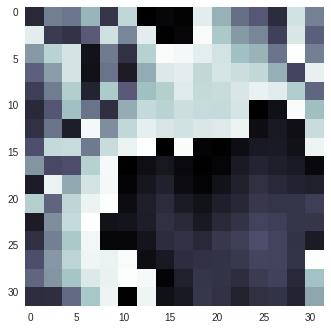

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import img_as_ubyte


idx = np.random.randint(data.shape[0])
plt.grid(False)
plt.imshow(np.array(data[idx,:,:,0], dtype=np.uint8),cmap=plt.cm.bone)
plt.show()

VGG19

 ==== Fold 0 ====
80142336/80134624 [==============================] - 7s 0us/step
TRANSFER_LEARNING_BASE_MODEL
MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)
RandomizedSearchCV took 88.69 seconds for 10 candidates parameter settings.
MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=580, learning_rate='constant',
       learning_rate_init=0.0005, max_iter=3000, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.001, validation_fraction=0.1,
       verbose=False, warm_start=False)
RandomizedSearchCV took 28.62 seconds for 5 candidates parameter settings.
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=7, p=2,
           weights='uniform')
RandomizedSearchCV took 343.11 seconds for 10 candidates parameter settings

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.

RandomizedSearchCV took 105.31 seconds for 10 candidates parameter settings.
SVC(C=4096, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=4000, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.

RandomizedSearchCV took 87.97 seconds for 10 candidates parameter settings.
SVC(C=8, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='poly',
  max_iter=4000, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


FINETUNE_TOP
FINETUNE_CNN
TRANSFER_LEARNING_FINETUNE_MODEL
MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)
RandomizedSearchCV took 147.38 seconds for 10 candidates parameter settings.
MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=469, learning_rate='constant',
       learning_rate_init=0.0005, max_iter=3000, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.001, validation_fraction=0.1,
       verbose=False, warm_start=False)
RandomizedSearchCV took 18.61 seconds for 5 candidates parameter settings.
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')
RandomizedSearchCV took 307.76 seconds for 10 candidates parameter settings.
RandomForestClassifier(bootstrap=True, class_weight='bala

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.

RandomizedSearchCV took 58.10 seconds for 10 candidates parameter settings.
SVC(C=4096, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=4000, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.

RandomizedSearchCV took 56.21 seconds for 10 candidates parameter settings.
SVC(C=1, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='poly',
  max_iter=4000, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

 ==== Fold 1 ====
TRANSFER_LEARNING_BASE_MODEL
MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)
RandomizedSearchCV took 136.98 seconds for 10 candidates parameter settings.
MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=761, learning_rate='constant',
       learning_rate_init=0.0005, max_iter=3000, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.001, validation_fraction=0.1,
       verbose=False, warm_start=False)
RandomizedSearchCV took 28.78 seconds for 5 candidates parameter settings.
KN

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.

RandomizedSearchCV took 110.71 seconds for 10 candidates parameter settings.
SVC(C=2, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=4000, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.

RandomizedSearchCV took 89.37 seconds for 10 candidates parameter settings.
SVC(C=8192, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='poly',
  max_iter=4000, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


FINETUNE_TOP
FINETUNE_CNN
TRANSFER_LEARNING_FINETUNE_MODEL
MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)
RandomizedSearchCV took 123.70 seconds for 10 candidates parameter settings.
MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=947, learning_rate='constant',
       learning_rate_init=0.0005, max_iter=3000, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.001, validation_fraction=0.1,
       verbose=False, warm_start=False)
RandomizedSearchCV took 18.94 seconds for 5 candidates parameter settings.
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=9, p=2,
           weights='uniform')
RandomizedSearchCV took 309.43 seconds for 10 candidates parameter settings.
RandomForestClassifier(bootstrap=False, class_weight='bal

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.

RandomizedSearchCV took 66.39 seconds for 10 candidates parameter settings.
SVC(C=0.5, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=4000, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.

RandomizedSearchCV took 58.67 seconds for 10 candidates parameter settings.
SVC(C=0.03125, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=9, gamma='auto', kernel='poly',
  max_iter=4000, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)



 ==== Fold 2 ====
TRANSFER_LEARNING_BASE_MODEL
MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)
RandomizedSearchCV took 149.24 seconds for 10 candidates parameter settings.
MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=897, learning_rate='constant',
       learning_rate_init=0.0005, max_iter=3000, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.001, validation_fraction=0.1,
       verbose=False, warm_start=False)
RandomizedSearchCV took 26.96 seconds for 5 candidates parameter settings.
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=7, p=2,
           weights='uniform')
RandomizedSearchCV took 303.32 seconds for 10 candidates parameter settings.
RandomForestClassifier(bootstrap=False, class_weight='balanced',
   

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.

RandomizedSearchCV took 110.25 seconds for 10 candidates parameter settings.
SVC(C=2, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=4000, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.

RandomizedSearchCV took 92.20 seconds for 10 candidates parameter settings.
SVC(C=0.125, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='poly',
  max_iter=4000, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


FINETUNE_TOP
FINETUNE_CNN
TRANSFER_LEARNING_FINETUNE_MODEL
MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)
RandomizedSearchCV took 91.23 seconds for 10 candidates parameter settings.
MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=954, learning_rate='constant',
       learning_rate_init=0.0005, max_iter=3000, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.001, validation_fraction=0.1,
       verbose=False, warm_start=False)
RandomizedSearchCV took 20.70 seconds for 5 candidates parameter settings.
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=7, p=2,
           weights='uniform')
RandomizedSearchCV took 383.45 seconds for 10 candidates parameter settings.
RandomForestClassifier(bootstrap=False, class_weight='bala

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.

RandomizedSearchCV took 59.43 seconds for 10 candidates parameter settings.
SVC(C=1, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=4000, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.

RandomizedSearchCV took 60.88 seconds for 10 candidates parameter settings.
SVC(C=8192, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='poly',
  max_iter=4000, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

 ==== Fold 3 ====
TRANSFER_LEARNING_BASE_MODEL
MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)
RandomizedSearchCV took 130.95 seconds for 10 candidates parameter settings.
MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=833, learning_rate='constant',
       learning_rate_init=0.0005, max_iter=3000, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.001, validation_fraction=0.1,
       verbose=False, warm_start=False)
RandomizedSearchCV took 28.58 seconds for 5 candidates parameter settings.

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.

RandomizedSearchCV took 110.58 seconds for 10 candidates parameter settings.
SVC(C=512, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=4000, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.

RandomizedSearchCV took 88.05 seconds for 10 candidates parameter settings.
SVC(C=64, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='poly',
  max_iter=4000, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


FINETUNE_TOP
FINETUNE_CNN
TRANSFER_LEARNING_FINETUNE_MODEL
MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)
RandomizedSearchCV took 110.18 seconds for 10 candidates parameter settings.
MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=896, learning_rate='constant',
       learning_rate_init=0.0005, max_iter=3000, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.001, validation_fraction=0.1,
       verbose=False, warm_start=False)
RandomizedSearchCV took 21.11 seconds for 5 candidates parameter settings.
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=7, p=2,
           weights='uniform')
RandomizedSearchCV took 326.94 seconds for 10 candidates parameter settings.
RandomForestClassifier(bootstrap=False, class_weight='bal

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.

RandomizedSearchCV took 57.66 seconds for 10 candidates parameter settings.
SVC(C=32, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=4000, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.

RandomizedSearchCV took 54.00 seconds for 10 candidates parameter settings.
SVC(C=16, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='poly',
  max_iter=4000, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

 ==== Fold 4 ====
TRANSFER_LEARNING_BASE_MODEL
MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)
RandomizedSearchCV took 90.64 seconds for 10 candidates parameter settings.
MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=558, learning_rate='constant',
       learning_rate_init=0.0005, max_iter=3000, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.001, validation_fraction=0.1,
       verbose=False, warm_start=False)
RandomizedSearchCV took 28.77 seconds for 5 candidates parameter settings.
KN

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.

RandomizedSearchCV took 105.28 seconds for 10 candidates parameter settings.
SVC(C=0.5, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=4000, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.

RandomizedSearchCV took 87.91 seconds for 10 candidates parameter settings.
SVC(C=64, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='poly',
  max_iter=4000, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


FINETUNE_TOP
FINETUNE_CNN
TRANSFER_LEARNING_FINETUNE_MODEL
MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)
RandomizedSearchCV took 77.62 seconds for 10 candidates parameter settings.
MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=924, learning_rate='constant',
       learning_rate_init=0.0005, max_iter=3000, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.001, validation_fraction=0.1,
       verbose=False, warm_start=False)
RandomizedSearchCV took 20.57 seconds for 5 candidates parameter settings.
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=9, p=2,
           weights='uniform')
RandomizedSearchCV took 369.32 seconds for 10 candidates parameter settings.
RandomForestClassifier(bootstrap=False, class_weight='bala

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.

RandomizedSearchCV took 59.76 seconds for 10 candidates parameter settings.
SVC(C=1024, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=4000, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.

RandomizedSearchCV took 57.29 seconds for 10 candidates parameter settings.
SVC(C=0.125, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='poly',
  max_iter=4000, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

 ==== Fold 5 ====
TRANSFER_LEARNING_BASE_MODEL
MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)
RandomizedSearchCV took 151.51 seconds for 10 candidates parameter settings.
MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=996, learning_rate='constant',
       learning_rate_init=0.0005, max_iter=3000, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.001, validation_fraction=0.1,
       verbose=False, warm_start=False)
RandomizedSearchCV took 28.51 seconds for 5 candidates parameter settings

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.

RandomizedSearchCV took 107.97 seconds for 10 candidates parameter settings.
SVC(C=0.25, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=4000, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.

RandomizedSearchCV took 88.12 seconds for 10 candidates parameter settings.
SVC(C=0.125, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='poly',
  max_iter=4000, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


FINETUNE_TOP
FINETUNE_CNN
TRANSFER_LEARNING_FINETUNE_MODEL
MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)
RandomizedSearchCV took 153.71 seconds for 10 candidates parameter settings.
MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=770, learning_rate='constant',
       learning_rate_init=0.0005, max_iter=3000, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.001, validation_fraction=0.1,
       verbose=False, warm_start=False)
RandomizedSearchCV took 22.19 seconds for 5 candidates parameter settings.
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=7, p=2,
           weights='uniform')
RandomizedSearchCV took 347.76 seconds for 10 candidates parameter settings.
RandomForestClassifier(bootstrap=False, class_weight='bal

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.

RandomizedSearchCV took 62.35 seconds for 10 candidates parameter settings.
SVC(C=0.0625, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=4000, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.

RandomizedSearchCV took 60.44 seconds for 10 candidates parameter settings.
SVC(C=32, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='poly',
  max_iter=4000, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

 ==== Fold 6 ====
TRANSFER_LEARNING_BASE_MODEL
MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)
RandomizedSearchCV took 144.22 seconds for 10 candidates parameter settings.
MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=697, learning_rate='constant',
       learning_rate_init=0.0005, max_iter=3000, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.001, validation_fraction=0.1,
       verbose=False, warm_start=False)
RandomizedSearchCV took 28.32 seconds for 5 candidates parameter settings.
K

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.

RandomizedSearchCV took 111.39 seconds for 10 candidates parameter settings.
SVC(C=0.03125, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=4000, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.

RandomizedSearchCV took 92.72 seconds for 10 candidates parameter settings.
SVC(C=1024, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='poly',
  max_iter=4000, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


FINETUNE_TOP
FINETUNE_CNN
TRANSFER_LEARNING_FINETUNE_MODEL
MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)
RandomizedSearchCV took 119.82 seconds for 10 candidates parameter settings.
MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=883, learning_rate='constant',
       learning_rate_init=0.0005, max_iter=3000, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.001, validation_fraction=0.1,
       verbose=False, warm_start=False)
RandomizedSearchCV took 19.11 seconds for 5 candidates parameter settings.
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=9, p=2,
           weights='uniform')
RandomizedSearchCV took 325.46 seconds for 10 candidates parameter settings.
RandomForestClassifier(bootstrap=False, class_weight='bal

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.

RandomizedSearchCV took 67.40 seconds for 10 candidates parameter settings.
SVC(C=4, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=4000, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.

RandomizedSearchCV took 65.63 seconds for 10 candidates parameter settings.
SVC(C=0.5, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='poly',
  max_iter=4000, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)



 ==== Fold 7 ====
TRANSFER_LEARNING_BASE_MODEL
MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)
RandomizedSearchCV took 135.56 seconds for 10 candidates parameter settings.
MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=875, learning_rate='constant',
       learning_rate_init=0.0005, max_iter=3000, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.001, validation_fraction=0.1,
       verbose=False, warm_start=False)
RandomizedSearchCV took 28.60 seconds for 5 candidates parameter settings.
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')
RandomizedSearchCV took 388.29 seconds for 10 candidates parameter settings.
RandomForestClassifier(bootstrap=False, class_weight='balanced',
   

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.

RandomizedSearchCV took 113.68 seconds for 10 candidates parameter settings.
SVC(C=32, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=4000, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.

RandomizedSearchCV took 92.58 seconds for 10 candidates parameter settings.
SVC(C=64, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='poly',
  max_iter=4000, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


FINETUNE_TOP
FINETUNE_CNN
TRANSFER_LEARNING_FINETUNE_MODEL
MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)
RandomizedSearchCV took 143.95 seconds for 10 candidates parameter settings.
MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=970, learning_rate='constant',
       learning_rate_init=0.0005, max_iter=3000, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.001, validation_fraction=0.1,
       verbose=False, warm_start=False)
RandomizedSearchCV took 20.16 seconds for 5 candidates parameter settings.
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=9, p=2,
           weights='uniform')
RandomizedSearchCV took 372.25 seconds for 10 candidates parameter settings.
RandomForestClassifier(bootstrap=False, class_weight='bal

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.

RandomizedSearchCV took 61.77 seconds for 10 candidates parameter settings.
SVC(C=0.03125, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=4000, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.

RandomizedSearchCV took 55.96 seconds for 10 candidates parameter settings.
SVC(C=0.5, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=9, gamma='auto', kernel='poly',
  max_iter=4000, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)



 ==== Fold 8 ====
TRANSFER_LEARNING_BASE_MODEL
MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)
RandomizedSearchCV took 125.02 seconds for 10 candidates parameter settings.
MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=848, learning_rate='constant',
       learning_rate_init=0.0005, max_iter=3000, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.001, validation_fraction=0.1,
       verbose=False, warm_start=False)
RandomizedSearchCV took 28.63 seconds for 5 candidates parameter settings.
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')
RandomizedSearchCV took 346.71 seconds for 10 candidates parameter settings.
RandomForestClassifier(bootstrap=False, class_weight='balanced',
   

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.

RandomizedSearchCV took 107.68 seconds for 10 candidates parameter settings.
SVC(C=0.25, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=4000, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.

RandomizedSearchCV took 89.02 seconds for 10 candidates parameter settings.
SVC(C=0.0625, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='poly',
  max_iter=4000, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


FINETUNE_TOP
FINETUNE_CNN
TRANSFER_LEARNING_FINETUNE_MODEL
MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)
RandomizedSearchCV took 123.25 seconds for 10 candidates parameter settings.
MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=572, learning_rate='constant',
       learning_rate_init=0.0005, max_iter=3000, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.001, validation_fraction=0.1,
       verbose=False, warm_start=False)
RandomizedSearchCV took 20.17 seconds for 5 candidates parameter settings.
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=9, p=2,
           weights='uniform')
RandomizedSearchCV took 366.12 seconds for 10 candidates parameter settings.
RandomForestClassifier(bootstrap=True, class_weight='bala

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.

RandomizedSearchCV took 58.92 seconds for 10 candidates parameter settings.
SVC(C=2, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=4000, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.

RandomizedSearchCV took 50.40 seconds for 10 candidates parameter settings.
SVC(C=8192, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='poly',
  max_iter=4000, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)



 ==== Fold 9 ====
TRANSFER_LEARNING_BASE_MODEL
MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)
RandomizedSearchCV took 111.65 seconds for 10 candidates parameter settings.
MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=704, learning_rate='constant',
       learning_rate_init=0.0005, max_iter=3000, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.001, validation_fraction=0.1,
       verbose=False, warm_start=False)
RandomizedSearchCV took 28.27 seconds for 5 candidates parameter settings.
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=9, p=2,
           weights='uniform')
RandomizedSearchCV took 414.25 seconds for 10 candidates parameter settings.
RandomForestClassifier(bootstrap=False, class_weight='balanced',
   

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.

RandomizedSearchCV took 109.37 seconds for 10 candidates parameter settings.
SVC(C=0.0625, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=4000, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.

RandomizedSearchCV took 89.58 seconds for 10 candidates parameter settings.
SVC(C=8192, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='poly',
  max_iter=4000, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


FINETUNE_TOP
FINETUNE_CNN
TRANSFER_LEARNING_FINETUNE_MODEL
MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)
RandomizedSearchCV took 109.82 seconds for 10 candidates parameter settings.
MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=834, learning_rate='constant',
       learning_rate_init=0.0005, max_iter=3000, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.001, validation_fraction=0.1,
       verbose=False, warm_start=False)
RandomizedSearchCV took 21.96 seconds for 5 candidates parameter settings.
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')
RandomizedSearchCV took 362.39 seconds for 10 candidates parameter settings.
RandomForestClassifier(bootstrap=False, class_weight='bal

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.

RandomizedSearchCV took 59.18 seconds for 10 candidates parameter settings.
SVC(C=256, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=4000, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.

RandomizedSearchCV took 58.22 seconds for 10 candidates parameter settings.
SVC(C=4096, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='poly',
  max_iter=4000, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
======================= TRANFER_LEARNING_BASE_MODEL_FINAL =======================
>>> Naive Bayes
             precision    recall  f1-score   support

          0       0.89      0.79      0.84       115
          1       0.54      0.72      0.62        39

avg / total       0.80      0.77      0.78       154

accuracy 0.7727272727272727
recall_micro 0.7727272727272727
recall_macro 0.7546265328874024
recall_weighted 0.7727272727272727
precision_micro 0.7727272727272727
precision_macro 0.7153092006033183
precision_weighted 0.8025846702317291
auc_micro 0.7546265328874024
auc_macro 0.7546265328874024
auc_weighted 0.7546265328874024


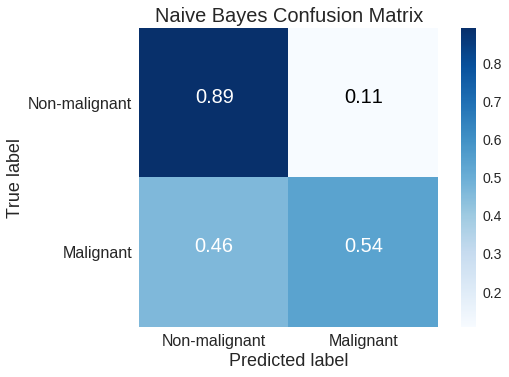

>>> Multilayer Perceptron
             precision    recall  f1-score   support

          0       0.86      0.90      0.88       115
          1       0.67      0.56      0.61        39

avg / total       0.81      0.82      0.81       154

accuracy 0.8181818181818182
recall_micro 0.8181818181818182
recall_macro 0.7342251950947603
recall_weighted 0.8181818181818182
precision_micro 0.8181818181818182
precision_macro 0.7630853994490359
precision_weighted 0.8106686701728024
auc_micro 0.7342251950947603
auc_macro 0.7342251950947603
auc_weighted 0.7342251950947603


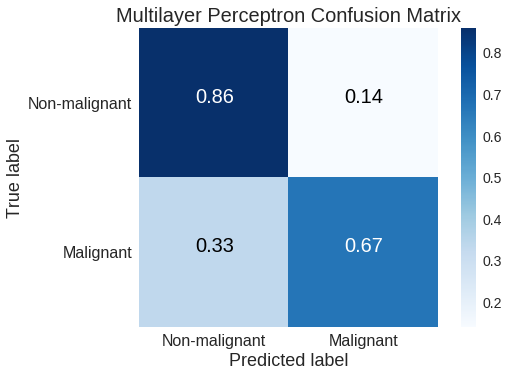

>>> Nearest_Neighbors
             precision    recall  f1-score   support

          0       0.89      0.90      0.89       115
          1       0.68      0.67      0.68        39

avg / total       0.84      0.84      0.84       154

accuracy 0.8376623376623377
recall_micro 0.8376623376623377
recall_macro 0.7811594202898551
recall_weighted 0.8376623376623377
precision_micro 0.8376623376623377
precision_macro 0.7860707803992741
precision_weighted 0.8363394772196951
auc_micro 0.7811594202898551
auc_macro 0.7811594202898551
auc_weighted 0.7811594202898551


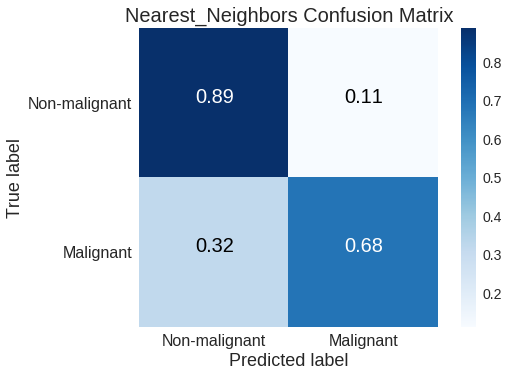

>>> Random Forest
             precision    recall  f1-score   support

          0       0.88      0.97      0.92       115
          1       0.88      0.59      0.71        39

avg / total       0.88      0.88      0.87       154

accuracy 0.8766233766233766
recall_micro 0.8766233766233766
recall_macro 0.7818283166109253
recall_weighted 0.8766233766233766
precision_micro 0.8766233766233766
precision_macro 0.8798076923076923
precision_weighted 0.877435064935065
auc_micro 0.7818283166109253
auc_macro 0.7818283166109253
auc_weighted 0.7818283166109253


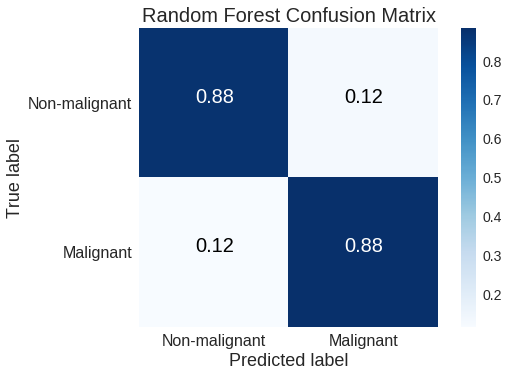

>>> SVM Linear
             precision    recall  f1-score   support

          0       0.82      0.77      0.79       115
          1       0.42      0.49      0.45        39

avg / total       0.72      0.70      0.71       154

accuracy 0.7012987012987013
recall_micro 0.7012987012987013
recall_macro 0.630546265328874
recall_weighted 0.7012987012987013
precision_micro 0.7012987012987013
precision_macro 0.6193679918450561
precision_weighted 0.7166607093212598
auc_micro 0.630546265328874
auc_macro 0.630546265328874
auc_weighted 0.630546265328874


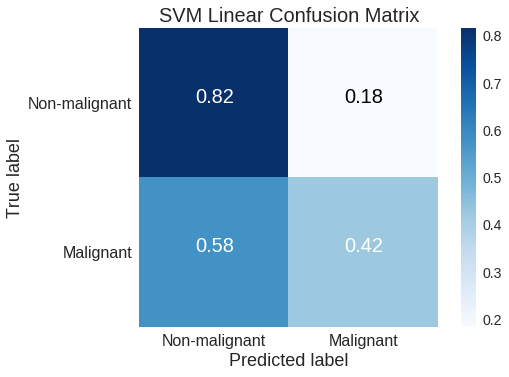

>>> SVM RBF
             precision    recall  f1-score   support

          0       0.86      0.86      0.86       115
          1       0.59      0.59      0.59        39

avg / total       0.79      0.79      0.79       154

accuracy 0.7922077922077922
recall_micro 0.7922077922077922
recall_macro 0.7253065774804905
recall_weighted 0.7922077922077922
precision_micro 0.7922077922077922
precision_macro 0.7253065774804905
precision_weighted 0.7922077922077922
auc_micro 0.7253065774804905
auc_macro 0.7253065774804905
auc_weighted 0.7253065774804905


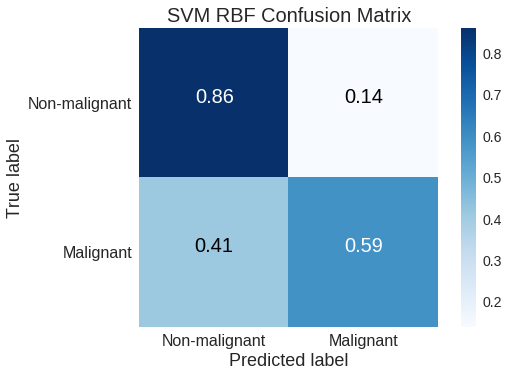

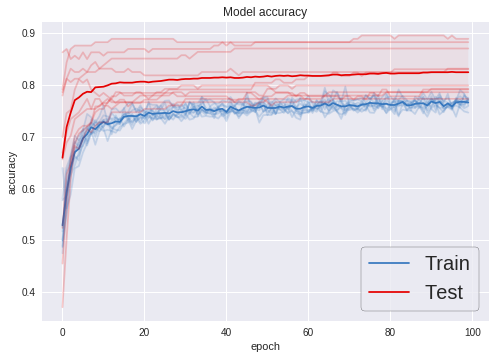

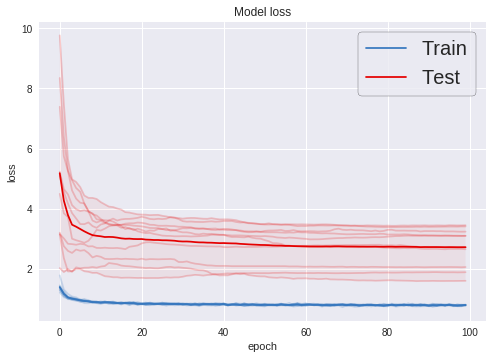

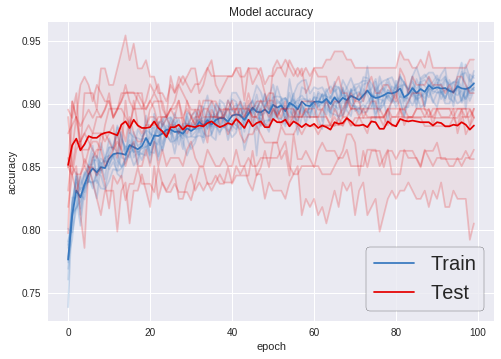

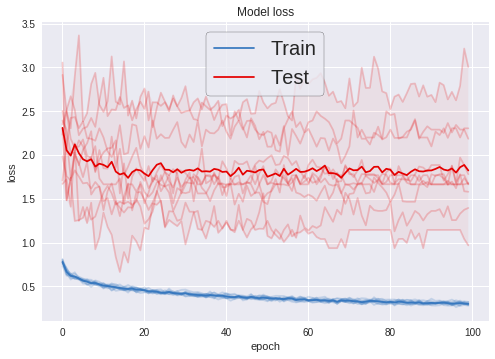

======================= TRANSFER_LEARNING_FINETUNE_MODEL_FINAL =======================
>>> Naive Bayes
             precision    recall  f1-score   support

          0       0.91      0.80      0.85       115
          1       0.57      0.77      0.65        39

avg / total       0.82      0.79      0.80       154

accuracy 0.7922077922077922
recall_micro 0.7922077922077922
recall_macro 0.7846153846153847
recall_weighted 0.7922077922077922
precision_micro 0.7922077922077922
precision_macro 0.7384644124789838
precision_weighted 0.8235580970495971
auc_micro 0.7846153846153847
auc_macro 0.7846153846153847
auc_weighted 0.7846153846153847


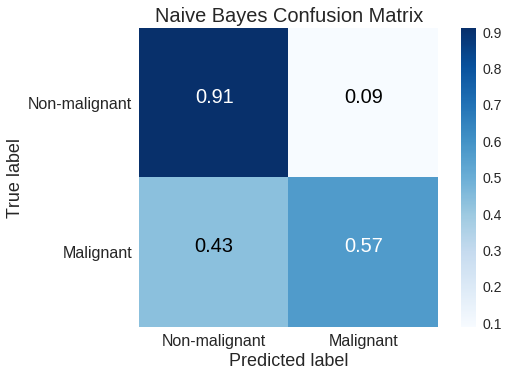

>>> Multilayer Perceptron
             precision    recall  f1-score   support

          0       0.89      0.89      0.89       115
          1       0.68      0.69      0.68        39

avg / total       0.84      0.84      0.84       154

accuracy 0.8376623376623377
recall_micro 0.8376623376623377
recall_macro 0.7896321070234114
recall_weighted 0.8376623376623377
precision_micro 0.8376623376623377
precision_macro 0.7848684210526315
precision_weighted 0.8390892002734107
auc_micro 0.7896321070234114
auc_macro 0.7896321070234114
auc_weighted 0.7896321070234114


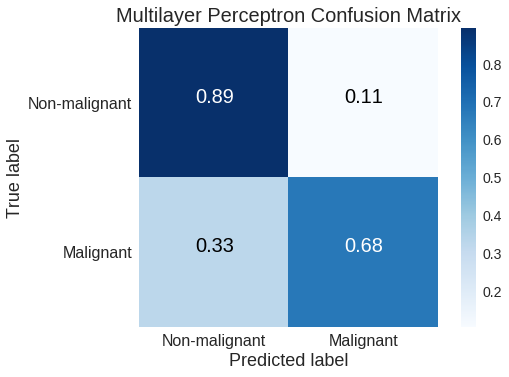

>>> Nearest_Neighbors
             precision    recall  f1-score   support

          0       0.91      0.94      0.92       115
          1       0.80      0.72      0.76        39

avg / total       0.88      0.88      0.88       154

accuracy 0.8831168831168831
recall_micro 0.8831168831168831
recall_macro 0.8285395763656633
recall_weighted 0.8831168831168831
precision_micro 0.8831168831168831
precision_macro 0.8537815126050421
precision_weighted 0.8803230383062316
auc_micro 0.8285395763656633
auc_macro 0.8285395763656633
auc_weighted 0.8285395763656633


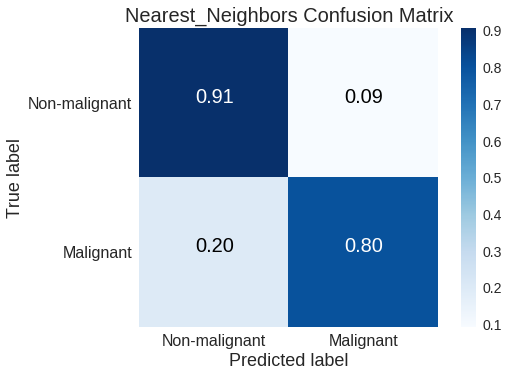

>>> Random Forest
             precision    recall  f1-score   support

          0       0.89      0.93      0.91       115
          1       0.76      0.67      0.71        39

avg / total       0.86      0.86      0.86       154

accuracy 0.8636363636363636
recall_micro 0.8636363636363636
recall_macro 0.7985507246376811
recall_weighted 0.8636363636363636
precision_micro 0.8636363636363636
precision_macro 0.8281862745098039
precision_weighted 0.8595142602495545
auc_micro 0.7985507246376811
auc_macro 0.7985507246376811
auc_weighted 0.7985507246376811


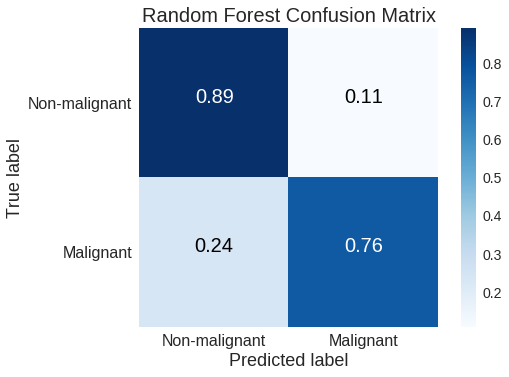

>>> SVM Linear
             precision    recall  f1-score   support

          0       0.88      0.92      0.90       115
          1       0.73      0.62      0.67        39

avg / total       0.84      0.84      0.84       154

accuracy 0.8441558441558441
recall_micro 0.8441558441558441
recall_macro 0.768561872909699
recall_weighted 0.8441558441558441
precision_micro 0.8441558441558441
precision_macro 0.8016528925619835
precision_weighted 0.8383599871203178
auc_micro 0.768561872909699
auc_macro 0.768561872909699
auc_weighted 0.768561872909699


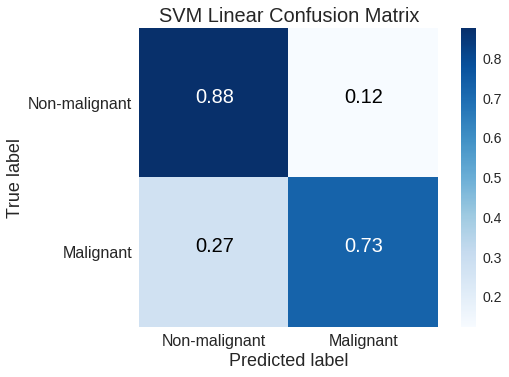

>>> SVM RBF
             precision    recall  f1-score   support

          0       0.89      0.88      0.89       115
          1       0.66      0.69      0.68        39

avg / total       0.83      0.83      0.83       154

accuracy 0.8311688311688312
recall_micro 0.8311688311688312
recall_macro 0.7852842809364549
recall_weighted 0.8311688311688312
precision_micro 0.8311688311688312
precision_macro 0.7761709475501835
precision_weighted 0.8342242691476448
auc_micro 0.7852842809364549
auc_macro 0.7852842809364549
auc_weighted 0.7852842809364549


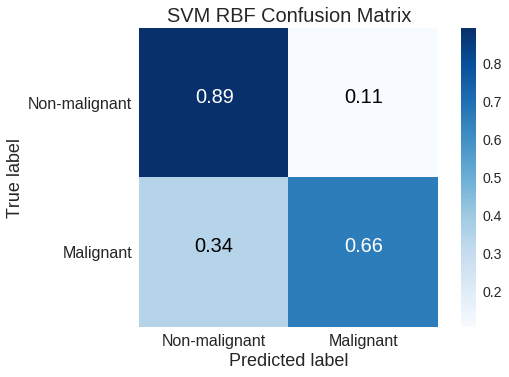

rm: cannot remove 'out': No such file or directory
20.1


In [22]:

for model_name,layer_unfreeze,crop_model_idx,lr_CNN,lr_FC in zip(model_name_list,layer_unfreeze_list,crop_model_idx_list,lr_CNN_list,lr_FC_list): ## TODO: Como organizar nesse caso?
    ###################################################################    
    print(model_name)
    # LOG variables
    log_base_model = []
    log_finetune_top = []
    log_finetune_cnn = []
    log_finetuned_model = []
    ###################################################################
    skf = StratifiedKFold(n_splits=K_fold,shuffle=True)
    for fold_id , (train, test) in enumerate(skf.split(data, labels)):    
        print('\n ==== Fold '+str(fold_id)+' ====')
        fold_out_path = out_path+'/'+str(fold_id)
        #################################################################
        # Create the base pre-trained model, remove the 'cropModelIdx' layers and 
        # Adapt the model to new input(img shape) and output(number of classes)
        model = buildModel(model_name,
                         data[0].shape,
                         num_classes,
                         crop_model_idx) 
#         if (fold_id == 0): model.summary()
        ################################################################
        stage_name = "TRANSFER_LEARNING_BASE_MODEL"
        print(stage_name)
        log_base_model.append(transfer_learning(model,
                                               data,labels,train,test,
                                               clf_list,clf_name_list,
                                               stage_name))         
        print_fold_log(log_base_model,
                       clf_name_list,
                       fold_out_path,
                       class_names,
                       show)
        #################################################################
        stage_name = "FINETUNE_TOP"
        print(stage_name)              
        log_finetune_top.append(fine_tune(model,
                                   data,labels,train,test,
                                   batch_size,epochs_FC,lr_FC,class_weight,
                                   fold_out_path,stage_name,datagen,show))
        ###############################################################
        model = unfreeze_model(model,layer_unfreeze)
        ################################################################
        stage_name = "FINETUNE_CNN"
        print(stage_name)

        log_finetune_cnn.append(fine_tune(model,
                                 data,labels,train,test,
                                 batch_size,epochs_CNN,lr_CNN,class_weight,
                                 fold_out_path,stage_name,datagen,show))
        #################################################################
        stage_name = "TRANSFER_LEARNING_FINETUNE_MODEL"
        print(stage_name)
        log_finetuned_model.append(transfer_learning(model,
                                           data,labels,train,test,
                                           clf_list,clf_name_list,
                                           stage_name))
        print_fold_log(log_finetuned_model,
                       clf_name_list,
                       fold_out_path,
                       class_names,show)
        ################################################################
        if (save): save_model(model,fold_out_path)
        del model         
    ###################################################################
    log_name = "TRANFER_LEARNING_BASE_MODEL_FINAL"
    final_evaluation(out_path,log_name,log_base_model,clf_name_list,class_names)
    ###################################################################
    log_name = "FINETUNE_TOP_FINAL"
    final_plot(log_finetune_top,log_name,out_path)
    ##################################################################
    log_name = "FINETUNE_CNN_FINAL"
    final_plot(log_finetune_cnn,log_name,out_path)
    ###################################################################
    log_name = "TRANSFER_LEARNING_FINETUNE_MODEL_FINAL"
    final_evaluation(out_path,log_name,log_finetuned_model,clf_name_list,class_names)
    ###################################################################
    file.close() 
    ##################################################################
    %notebook -e ./out/Notebook.ipynb
    ###################################################################
    filename = model_name+'_'+str(layer_unfreeze)+'_'+str(crop_model_idx)+'_'+str(lr_CNN)+'_'+str(lr_FC)+'.zip'
    export_log(out_folder_id,filename)
    ###################################################################
    !rm -r out 
print(psutil.virtual_memory().percent)


In [23]:
model_name_list,layer_unfreeze_list,crop_model_idx_list,lr_CNN_list,lr_FC_list

(['VGG19', 'VGG19', 'VGG19', 'VGG19', 'VGG19', 'VGG19'],
 [-10, -10, -10, -10, -10],
 [-1, -1, -1, -1, -1],
 [0.0001],
 [0.0005, 0.0005, 0.0005, 0.0005, 0.0005])

In [24]:
print(psutil.virtual_memory().percent)


20.0


In [0]:
import pandas as pd